<a href="https://colab.research.google.com/github/UKJaagadhep/Data-science-and-machine-learning/blob/main/Speech%20Recognition%20Skeleton/Speech_Recognition_Skeleton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.layers import Normalization, Input, Conv2D, LayerNormalization, Reshape, Bidirectional, GRU, Dense

In [29]:
frame_length = 255
frame_step = 128
batch_size = 32
learning_rate = 1e-4
n_epochs = 20

# **DATA DOWNLOAD**

In [3]:
!wget https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2

--2024-06-20 10:15:23--  https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2
Resolving data.keithito.com (data.keithito.com)... 24.199.73.137
Connecting to data.keithito.com (data.keithito.com)|24.199.73.137|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2748572632 (2.6G) [text/plain]
Saving to: ‘LJSpeech-1.1.tar.bz2’

LJSpeech-1.1.tar.bz 100%[===================>]   2.56G  21.3MB/s    in 2m 6s   

2024-06-20 10:17:30 (20.8 MB/s) - ‘LJSpeech-1.1.tar.bz2’ saved [2748572632/2748572632]



In [4]:
!mkdir "/content/dataset/"

In [5]:
!tar -xjvf "/content/LJSpeech-1.1.tar.bz2" -C "/content/dataset/"

Streaming output truncated to the last 5000 lines.
LJSpeech-1.1/wavs/LJ022-0089.wav
LJSpeech-1.1/wavs/LJ030-0192.wav
LJSpeech-1.1/wavs/LJ041-0078.wav
LJSpeech-1.1/wavs/LJ045-0249.wav
LJSpeech-1.1/wavs/LJ034-0035.wav
LJSpeech-1.1/wavs/LJ010-0152.wav
LJSpeech-1.1/wavs/LJ036-0174.wav
LJSpeech-1.1/wavs/LJ035-0076.wav
LJSpeech-1.1/wavs/LJ032-0176.wav
LJSpeech-1.1/wavs/LJ046-0113.wav
LJSpeech-1.1/wavs/LJ017-0096.wav
LJSpeech-1.1/wavs/LJ004-0098.wav
LJSpeech-1.1/wavs/LJ010-0147.wav
LJSpeech-1.1/wavs/LJ042-0230.wav
LJSpeech-1.1/wavs/LJ041-0033.wav
LJSpeech-1.1/wavs/LJ045-0229.wav
LJSpeech-1.1/wavs/LJ014-0199.wav
LJSpeech-1.1/wavs/LJ002-0082.wav
LJSpeech-1.1/wavs/LJ006-0055.wav
LJSpeech-1.1/wavs/LJ045-0120.wav
LJSpeech-1.1/wavs/LJ050-0028.wav
LJSpeech-1.1/wavs/LJ045-0215.wav
LJSpeech-1.1/wavs/LJ013-0121.wav
LJSpeech-1.1/wavs/LJ008-0025.wav
LJSpeech-1.1/wavs/LJ005-0240.wav
LJSpeech-1.1/wavs/LJ044-0026.wav
LJSpeech-1.1/wavs/LJ048-0127.wav
LJSpeech-1.1/wavs/LJ006-0195.wav
LJSpeech-1.1/wavs/LJ030-0

# **DATA VISUALIZATION**

In [ ]:
audio_binary = tf.io.read_file("/content/dataset/LJSpeech-1.1/wavs/LJ001-0001.wav")
audio, audio_metadata = tf.audio.decode_wav(audio_binary)
waveform = tf.squeeze(audio, axis = -1)
waveform = tf.cast(waveform, tf.float32)
signal = waveform
print(signal.shape)

'''1) audio_binary = tf.io.read_file("/content/dataset/LJSpeech-1.1/wavs/LJ005-0065.wav") reads the binary
    content of the .wav file
   2) audio, audio_metadata = tf.audio.decode_wav(audio_binary) decodes .wac file into a float tensor containing
    waveform data. audio_metadata can be metadata like sample rate.
   3) waveform = tf.squeeze(audio, axis = -1)  removes dimensions of size 1 from the shape of the tensor.
    For audio data, this typically reduces the dimensions from (num_samples, 1) to (num_samples).
   4) waveform = tf.squeeze(audio, axis = -1)0
      waveform = tf.cast(waveform, tf.float32)
      These two lines are not always necessary as the decoded audio may already be in that format'''
''''''

(212893,)


''

Text(0, 0.5, 'amplitude')

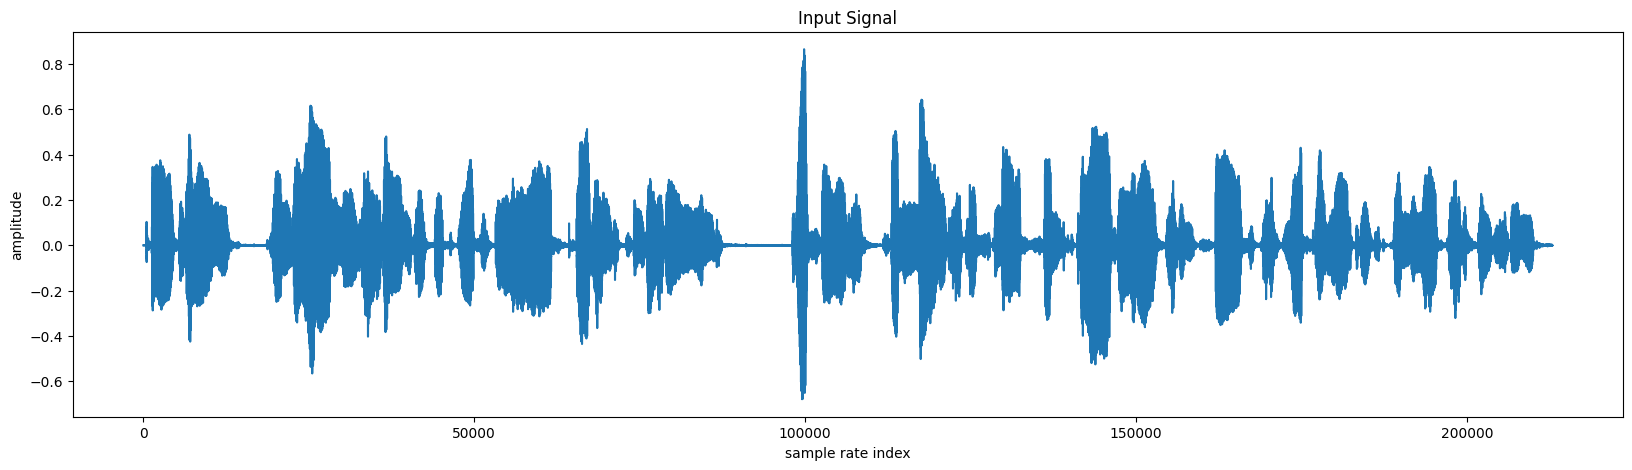

In [ ]:
plt.figure(figsize = (20, 5))
plt.plot(signal)
plt.title("Input Signal")
plt.xlabel("sample rate index")
plt.ylabel("amplitude")

Text(0, 0.5, 'amplitude')

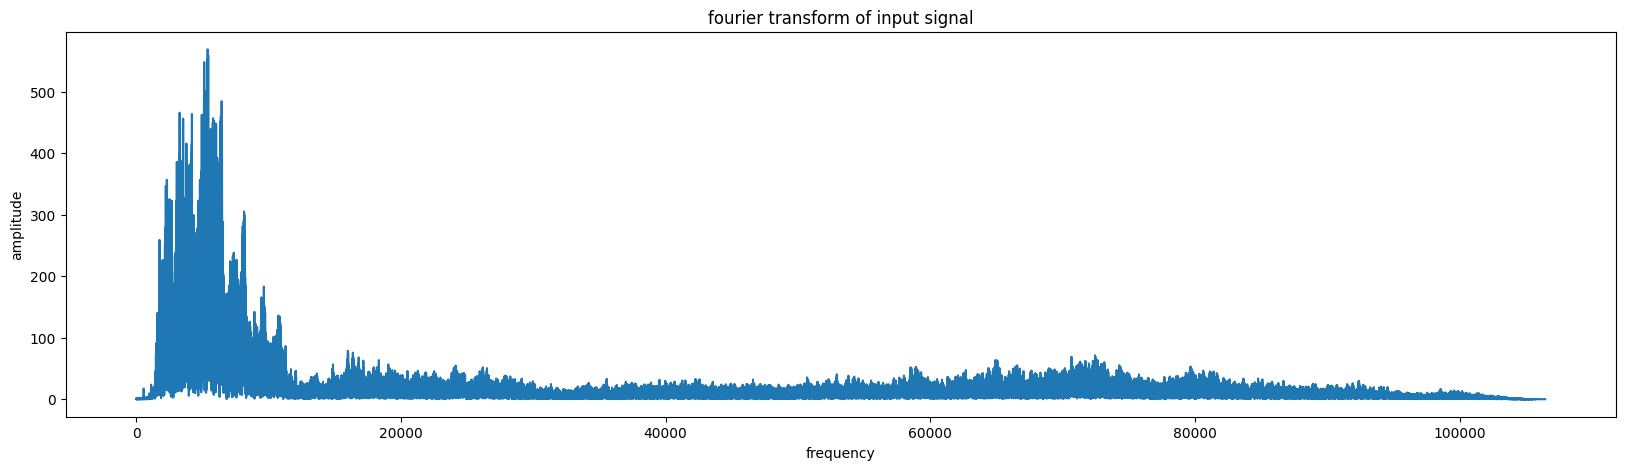

In [ ]:
plt.figure(figsize = (20, 5))
fourier_transform = tf.signal.rfft(signal)
plt.plot(tf.abs(fourier_transform))
plt.title("fourier transform of input signal")
plt.xlabel("frequency")
plt.ylabel("amplitude")

Text(0, 0.5, 'frequency')

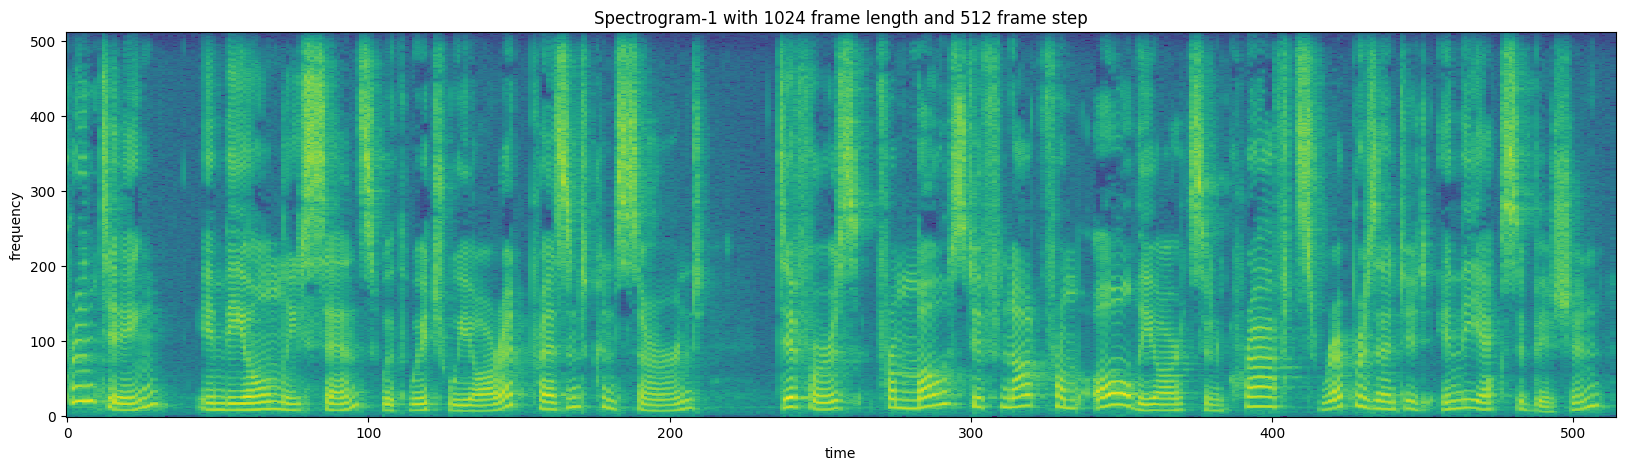

In [ ]:
spec = tf.signal.stft(signal, frame_length = 1024, frame_step = 512) #short time fourier transform (stft)
spec = tf.transpose(tf.abs(spec), [1,0]) #switches rows and columns for correct orientation for plotting

#converts magnitude spectrogram (due to tf.abs) to log-power spectrogram
power_spec = np.log(spec)

height = power_spec.shape[0] #no. of frequency bins
width = power_spec.shape[1] #no. of time frames

x = np.linspace(0, power_spec.shape[0], num = width, dtype = int) #equally spaced time values
y = range(height) #range of frequency values representing frequency bins

plt.figure(figsize = (20, 5))
plt.pcolormesh(x, y, power_spec) #pcolormesh = pseudo color mesh
plt.title("Spectrogram-1 with 1024 frame length and 512 frame step")
plt.xlabel("time")
plt.ylabel("frequency")

Text(0, 0.5, 'frequency')

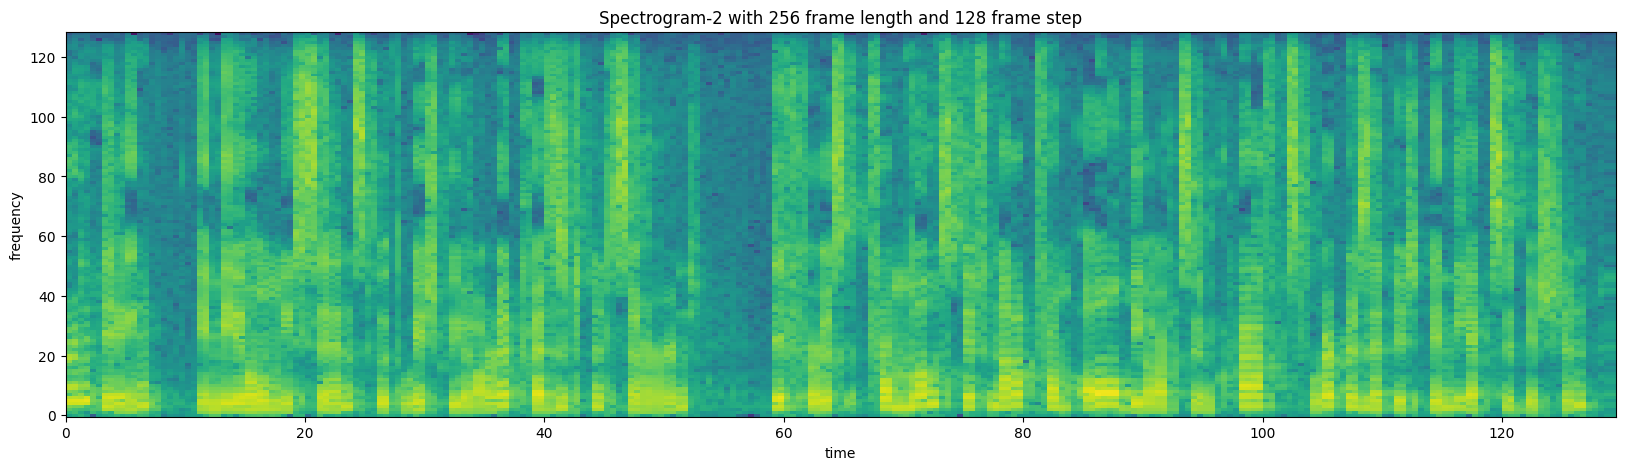

In [ ]:
spec = tf.signal.stft(signal, frame_length = 256, frame_step = 128)
spec = tf.transpose(tf.abs(spec), [1,0])

power_spec = np.log(spec)
height = power_spec.shape[0]
width = power_spec.shape[1]

x = np.linspace(0, power_spec.shape[0], num = width, dtype = int)
y = range(height)

plt.figure(figsize = (20, 5))
plt.pcolormesh(x, y, power_spec)
plt.title("Spectrogram-2 with 256 frame length and 128 frame step")
plt.xlabel("time")
plt.ylabel("frequency")

Text(0, 0.5, 'frequency')

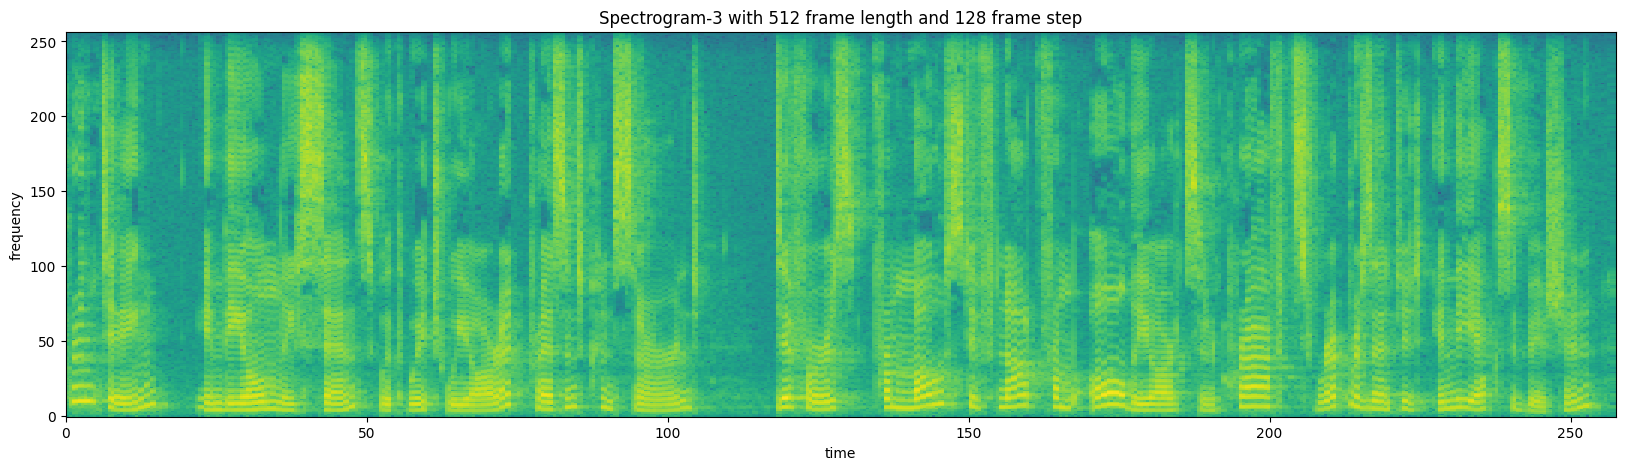

In [ ]:
spec = tf.signal.stft(signal, frame_length = 512, frame_step = 128)
spec = tf.transpose(tf.abs(spec), [1,0])

power_spec = np.log(spec)
height = power_spec.shape[0]
width = power_spec.shape[1]

x = np.linspace(0, power_spec.shape[0], num = width, dtype = int)
y = range(height)

plt.figure(figsize = (20, 5))
plt.pcolormesh(x, y, power_spec)
plt.title("Spectrogram-3 with 512 frame length and 128 frame step")
plt.xlabel("time")
plt.ylabel("frequency")

# **DATASET PREPARATION**

In [6]:
audio_text = {}

csv_path = "/content/dataset/LJSpeech-1.1/metadata.csv"

with open(csv_path, encoding = 'utf-8') as f:
  for line in f:
    audio_file_name = line.strip().split("|")[0]
    audio_file_transciption_text = line.strip().split("|")[1]
    audio_text[str(audio_file_name)] = audio_file_transciption_text

In [7]:
filepaths = ["/content/dataset/LJSpeech-1.1/wavs/" + filename + ".wav" for filename in list(audio_text.keys())]
transcriptions = [audio_text[str(filename)].lower() for filename in list(audio_text.keys())]
print(len(filepaths))
print(len(transcriptions))

13100
13100


In [8]:
dataset = tf.data.Dataset.from_tensor_slices((filepaths, transcriptions))

In [9]:
for i in dataset.take(1):
  print(i)

(<tf.Tensor: shape=(), dtype=string, numpy=b'/content/dataset/LJSpeech-1.1/wavs/LJ001-0001.wav'>, <tf.Tensor: shape=(), dtype=string, numpy=b'printing, in the only sense with which we are at present concerned, differs from most if not from all the arts and crafts represented in the exhibition'>)


In [9]:
#we create a vocabulary containing all letters in lowercase alongwith some special characters like punctuations for encoding transcriptions
#transcriptions are outputs
vocabulary = [""] + [chr(i) for i in range(97, 97+26)] + [".", ",", "?", " "]
print(vocabulary)
print(len(vocabulary))

['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '.', ',', '?', ' ']
31


In [10]:
def decode_audio(audio_binary):
    audio, _ = tf.audio.decode_wav(audio_binary)
    return tf.squeeze(audio, axis = -1)

In [11]:
def get_label(label,):
    #we will carry out predictions in the character level
    #for each character (including punctuation and space) in a transcription we put its index on the vocabulary list in label in its place
    #so the inputs and outputs to this function may not be of the same length (line len k = 1 but len 11 (k position index in vocabulary list) = 2)
    #character tokens in transcription and not in vocabulary will be taken as "" (position 0). "" is out-of-vocabulary token
    label = tf.strings.unicode_split(label, input_encoding = "UTF-8") #splits character (unicode) wise
    label = tf.keras.layers.StringLookup(vocabulary = vocabulary, oov_token = "")(label) #oov = out-of-vocabulary
    #tf.keras.layers.StringLookup is a preprocessing layer which maps string features to integer indices
    return label

In [12]:
def get_spec(filepath, label): #label is transcription

  audio_binary = tf.io.read_file(filepath)
  waveform = decode_audio(audio_binary)
  waveform = tf.cast(waveform, tf.float32)

  spectrogram = tf.signal.stft(
      waveform, frame_length = frame_length, frame_step = frame_step) #stft may output complex (not real) numbers
  spectrogram = tf.abs(spectrogram)
  label = get_label(label)
  return tf.expand_dims(spectrogram, axis = -1), label

In [13]:
processed_dataset = (
    dataset.map(get_spec, num_parallel_calls = tf.data.AUTOTUNE)
    .padded_batch(batch_size) #because different inputs (spectrograms) and outputs (labels) have different lengths
    .prefetch(buffer_size = tf.data.AUTOTUNE)
)

In [14]:
train_dataset = processed_dataset.take(int(0.95 * len(processed_dataset)))
val_dataset = processed_dataset.skip(int(0.95 * len(processed_dataset)))

In [16]:
for i, j in train_dataset.take(1):
  print(i, j)

tf.Tensor(
[[[[7.12798326e-04]
   [4.62571252e-03]
   [6.20642118e-03]
   ...
   [1.35252893e-04]
   [7.60609837e-05]
   [3.36043013e-05]]

  [[4.23590001e-03]
   [7.16409134e-03]
   [3.25928186e-03]
   ...
   [9.35658172e-05]
   [5.88824805e-05]
   [2.21005175e-05]]

  [[3.52023495e-03]
   [1.79913230e-02]
   [2.51728315e-02]
   ...
   [3.46498855e-04]
   [1.54141060e-04]
   [1.43282465e-04]]

  ...

  [[0.00000000e+00]
   [0.00000000e+00]
   [0.00000000e+00]
   ...
   [0.00000000e+00]
   [0.00000000e+00]
   [0.00000000e+00]]

  [[0.00000000e+00]
   [0.00000000e+00]
   [0.00000000e+00]
   ...
   [0.00000000e+00]
   [0.00000000e+00]
   [0.00000000e+00]]

  [[0.00000000e+00]
   [0.00000000e+00]
   [0.00000000e+00]
   ...
   [0.00000000e+00]
   [0.00000000e+00]
   [0.00000000e+00]]]


 [[[5.27175982e-03]
   [8.09575524e-03]
   [1.60869583e-02]
   ...
   [1.84489501e-04]
   [1.14731905e-04]
   [1.01984711e-04]]

  [[5.57353161e-03]
   [1.64909065e-02]
   [1.31872818e-01]
   ...
   [1.4453

In [ ]:
tf.data.experimental.save(train_dataset, "/content/train_dataset")
tf.data.experimental.save(val_dataset, "/content/val_dataset")

Instructions for updating:
Use `tf.data.Dataset.save(...)` instead.


# **MODELING**

In [15]:
#A simplified verion of the Deep Speech 2 model
#parameters like kernel size and strides are the same as in the paper
#we use layer normalization instead of batch normalization (given in the Deep Speech 2 paper) here

input_spectrogram = Input((None, 129, 1), name = 'input') #None denotes varying time steps in time axis for the inputs, 129 is the frequency range in the frequency axis
x = Normalization()(input_spectrogram)

x = Conv2D(32, kernel_size = (11, 41), strides = (2, 2), padding = 'same', activation = 'relu')(x)
x = LayerNormalization()(x)
x = Conv2D(64, kernel_size = (11, 21), strides = (1, 2), padding = 'same', activation = 'relu')(x)
x = LayerNormalization()(x)

x = Reshape((-1, x.shape[-2] * x.shape[-1]))(x)

x = Bidirectional(GRU(128, return_sequences = True))(x)
x = Bidirectional(GRU(128, return_sequences = True))(x)
x = Bidirectional(GRU(128, return_sequences = True))(x)

output = Dense(len(vocabulary) + 1, activation = 'softmax')(x) #we add 1 due to link between different predictions of the model

model = tf.keras.Model(input_spectrogram, output, name = 'DeepSpeech_2')
model.summary()

Model: "DeepSpeech_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, None, 129, 1)]    0         
                                                                 
 normalization (Normalizati  (None, None, 129, 1)      3         
 on)                                                             
                                                                 
 conv2d (Conv2D)             (None, None, 65, 32)      14464     
                                                                 
 layer_normalization (Layer  (None, None, 65, 32)      64        
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, None, 33, 64)      473152    
                                                                 
 layer_normalization_1 (Lay  (None, None, 33, 64)     

In [16]:
def ctc_loss(y_true, y_pred):
  batch_size = tf.shape(y_pred)[0]
  pred_length = tf.shape(y_pred)[1]
  true_length = tf.shape(y_true)[1]

  pred_length = pred_length * tf.ones([batch_size, 1], dtype = tf.int32)
  true_length = true_length * tf.ones([batch_size, 1], dtype = tf.int32)

  return tf.keras.backend.ctc_batch_cost(y_true, y_pred, pred_length, true_length)

In [17]:
model.compile(loss = ctc_loss, optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate))

In [ ]:
history = model.fit(
  train_dataset,
  validation_data = val_dataset,
  epochs = n_epochs
)

Epoch 1/20
389/389 [==============================] - 818s 2s/step - loss: 158.6078 - val_loss: 143.8949
Epoch 2/20
389/389 [==============================] - 820s 2s/step - loss: 129.6761 - val_loss: 120.8194
Epoch 3/20
389/389 [==============================] - 816s 2s/step - loss: 112.5177 - val_loss: 106.2635
Epoch 4/20
389/389 [==============================] - 810s 2s/step - loss: 100.9980 - val_loss: 96.1829
Epoch 5/20
389/389 [==============================] - 816s 2s/step - loss: 92.5757 - val_loss: 89.0987
Epoch 6/20


In [21]:
model.save_weights('/content/speech_recognition.h5')

# **TESTING**

In [22]:
def get_spec_inference(filepath):

  audio_binary = tf.io.read_file(filepath)
  waveform = decode_audio(audio_binary)
  waveform = tf.cast(waveform, tf.float32)

  spectrogram = tf.signal.stft(waveform, frame_length = frame_length, frame_step = frame_step)

  spectrogram = tf.abs(spectrogram)

  return tf.expand_dims(spectrogram, axis = -1)

In [23]:
test_path = "/content/dataset/LJSpeech-1.1/wavs/LJ001-0002.wav"

In [24]:
spectrogram = get_spec_inference(test_path)
print(spectrogram.shape)
out = tf.argmax(model.predict(tf.expand_dims(spectrogram, axis = 0))[0], axis = 1)

(326, 129, 1)
1/1 [==============================] - 2s 2s/step


In [25]:
out_list = [vocabulary[i] if i != 31 else "[LINK]" for i in out]
#vocabulary list has 31 elements (so index from 0 to 30). So if i = 31, we consider it as [LINK] character in CTC loss algorithm.
out_str = "".join(out_list) #predicted text in CTC loss form

In [26]:
print(out_str)

[LINK][LINK]i[LINK][LINK][LINK]nn[LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK] c[LINK][LINK]ooo[LINK][LINK][LINK][LINK][LINK][LINK][LINK] p[LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK]r[LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK]t[LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK]e[LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK]


In [27]:
def decode(y_pred):
  batch_size = tf.shape(y_pred)[0]
  pred_length = tf.shape(y_pred)[1]

  pred_length = pred_length * tf.ones([batch_size,], dtype = tf.int32)

  y_pred = tf.one_hot(y_pred, len(vocabulary) + 1)
  # 1 ---> [0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0] (list length = 32) for each element in y_pred

  output = tf.keras.backend.ctc_decode(y_pred, input_length = pred_length, greedy = True)[0][0] #greedy=True means decoding should use greedy algorithm (selecting the most probable class at each time step).
  #The result of ctc_decode is a list of decoded sequences. [0][0] is used to extract the first sequence from this list.

  out = [vocabulary[i] for i in output[0]]
  return ''.join(out)

In [ ]:
print(decode(tf.expand_dims(out, axis = 0)))